# 🌳 Decision Tree Classifier from Scratch (Entropy/IG)
This notebook implements a complete Decision Tree Classifier using NumPy and Pandas. The model is trained using **Information Gain** based on **Entropy** as its core splitting criterion.

The final section demonstrates proper model evaluation using the Confusion Matrix and Classification Report.

### Setup and Library Imports
We start by importing the necessary libraries. We will use `pandas` for data handling, `numpy` for core calculations, and `sklearn.metrics` for professional evaluation.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Decision Tree Core Components: Node and Class Structure
A Decision Tree is composed of Nodes. Each node either holds a decision (a question about a feature) or a prediction (a leaf node). This block contains the self-contained implementation of the Node and DecisionTree classes.

## The Node Class
The `Node` class holds the structure of the tree.

* Internal Nodes store `feature_index` and `threshold` to make a decision, and links to `left_child` and `right_child` nodes.

* The `threshold` handels binary data well as well can be used for numerical data.

* Leaf Nodes store the final `value` (the predicted class/diagnosis).





In [3]:
class Node:
    """
    Represents a single node in the decision tree.
    It can be either an internal node (decision node) or a leaf node (prediction).
    """
    def __init__(self, feature_index=None, threshold=None, left_child=None, right_child=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.value = value


## The decision tree class

* The `fit` method encodes the labels and calls `build_tree` with the encoded labels.

* The `build_tree` method uses the methid `find_best_split` to recursively builds the tree until a stopping condition is met.

* The `find_best_split` method calculates the Information Gain, which requires the `_calculate_entropy` method, to finds the best feature/threshold to split on.

* The Entropy method calculates the disorder of the data.

* To make predictions the methods `predict` and `_predict_single` are used.



In [25]:
class DecisionTree:
    """
    Implements a Decision Tree Classifier from scratch.
    """
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def _calculate_entropy(self, y):
        """
        Calculates the Entropy for a set of labels.
        """
        classes, counts = np.unique(y, return_counts=True) # Get unique classes and their counts, only counts are used
        total_samples = len(y) # Total number of samples
        if total_samples == 0:
            return 0
        entropy = 0.0
        for count in counts:
            proportion = count / total_samples # Proportion of each class
            if proportion > 0:
                entropy -= proportion * np.log2(proportion) # Entropy formula, calculated only for non-zero proportions
        return entropy

    def _best_split(self, X, y):
        """
        Finds the best feature and threshold to split the data based on Information Gain.
        """
        best_info_gain = -1.0  # Initialize to -1 to ensure any valid split is better
        best_feature_index = None
        best_threshold = None
        n_features = X.shape[1]
        parent_entropy = self._calculate_entropy(y) # Entropy before the split (Parent node)

        # Iterate over all features and possible thresholds and calculate each split's information gain
        # Thresholds works well for binary features (0, 1) and can be used for continuous features as well
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index]) # for binary features, this will be [0, 1]
            for threshold in thresholds:
                # Split the dataset based on feature and threshold
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]

                if len(left_indices) == 0 or len(right_indices) == 0: # Skip trivial splits --> Binary features when threshold is 1 because no features are > 1
                    continue

                # Calculate the entropy for the left and right splits
                y_left, y_right = y[left_indices], y[right_indices]
                entropy_left = self._calculate_entropy(y_left)
                entropy_right = self._calculate_entropy(y_right)

                n_left, n_right = len(y_left), len(y_right)
                total_samples = n_left + n_right
                # calculate the weighted average entropy after the split and the information gain
                weighted_avg_entropy = (n_left / total_samples) * entropy_left + (n_right / total_samples) * entropy_right
                information_gain = parent_entropy - weighted_avg_entropy

                # Update the best split if the current one is better
                if information_gain > best_info_gain:
                    best_info_gain = information_gain
                    best_feature_index = feature_index
                    best_threshold = threshold
        
        if best_info_gain <= 0:
            return None, None
            
        return best_feature_index, best_threshold

    def _build_tree(self, X, y, depth=0):
        '''
        Recursively builds the decision tree.
        '''

        # Stopping conditions
        if len(np.unique(y)) == 1: # All samples belong to the same class --> leaf node
            return Node(value=y[0]) 
        if len(y) < self.min_samples_split: # Not enough samples to split --> leaf node
            return Node(value=np.bincount(y).argmax()) # Majority class
        if depth >= self.max_depth: # Max depth reached --> leaf node
            return Node(value=np.bincount(y).argmax()) # Majority class

        feature_index, threshold = self._best_split(X, y)

        if feature_index is None: # No valid split found --> leaf node
            return Node(value=np.bincount(y).argmax()) # Majority class

        # Split the dataset
        left_indices = np.where(X[:, feature_index] <= threshold)[0]
        right_indices = np.where(X[:, feature_index] > threshold)[0]
        
        if len(left_indices) == 0 or len(right_indices) == 0: # Trivial split --> leaf node
            return Node(value=np.bincount(y).argmax()) # Majority class

        # Recursively build the left and right subtrees 
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        # Create the internal node
        return Node(feature_index=feature_index, threshold=threshold,
                    left_child=left_child, right_child=right_child)

    def fit(self, X, y):
        '''
        Fits the decision tree to the training data X and labels y.
        '''
        # Create two dictionaries for label encoding and decoding
        self.label_encoder = {} # Map original labels to integers
        self.reverse_label_encoder = {} # Map integers back to original labels
        unique_labels = np.unique(y) # Find unique labels in the training data
        for i, label in enumerate(unique_labels):
            self.label_encoder[label] = i
            self.reverse_label_encoder[i] = label
   
        y_encoded = np.array([self.label_encoder[label] for label in y]) # Encode labels to integers to train the model
        self.root = self._build_tree(X, y_encoded) # Build the tree and set the root node

    def _predict_single(self, x, node):
        '''
        Predicts the class label for a single sample x by traversing the tree.
        '''
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict_single(x, node.left_child)
        else:
            return self._predict_single(x, node.right_child)

    def predict(self, X):
        '''
        Predicts the class labels for the input samples X.
        '''
        predictions_encoded = [self._predict_single(x, self.root) for x in X] # Get encoded predictions (in line loop)
        predictions = [self.reverse_label_encoder[pred_encoded] for pred_encoded in predictions_encoded] # Decode predictions
        return np.array(predictions)
    

    # Visualization method for understanding the tree structure
    def visualize_tree(self, feature_names):
        """
        Public method: Prints the structure of the trained decision tree with visual lines.
        Requires the list of feature names (e.g., ['itching', 'fatigue']).
        """
        if self.root:
            print("\n--- Trained Decision Tree Structure ---")
            # Start the recursive print function
            self._print_tree(self.root, feature_names)

    def _print_tree(self, node, feature_names, prefix="", is_last=True):
        """
        Private method: Recursive helper for printing the tree structure.
        Uses Unicode characters for a cleaner, tree-like structure.
        """
        
        # 1. Leaf Node (Base Case)
        if node.value is not None:
            # Print the final prediction using the 'last' branch connector
            print(f"{prefix}{'└── ' if is_last else '├── '}📚 PREDICT: {node.value}")
            return

        # 2. Internal Node (Decision Point)
        feature_name = feature_names[node.feature_index]
        condition = f"{feature_name} <= {node.threshold}"
        
        # Determine the connector and extension for the current level
        connector = "└── " if is_last else "├── "
        extension = "    " if is_last else "│   "

        # Print the split condition. Root node is special (no line connector)
        if node is self.root:
            print(f"🌳 ROOT SPLIT: {condition}?")
            next_prefix = ""
        else:
            print(f"{prefix}{connector}❓ SPLIT: {condition}?")
            next_prefix = prefix + extension
            
        # 3. Recurse Left Child (YES Branch) - Treated as the 'first' branch (is_last=False)
        # We explicitly print the YES/NO branch text for clarity.
        print(f"{next_prefix}├── YES (<= {node.threshold})")
        self._print_tree(node.left_child, feature_names, next_prefix + "│   ", is_last=False)

        # 4. Recurse Right Child (NO Branch) - Treated as the 'last' branch (is_last=True)
        # The prefix for the right branch uses spaces instead of the vertical line
        right_prefix = prefix + ("    " if is_last else "│   ")
        print(f"{right_prefix}└── NO ( > {node.threshold})")
        self._print_tree(node.right_child, feature_names, right_prefix + "    ", is_last=True)


# Data preprocessing
Transforms the data set, which consists of strings and has only 17 columns for the total of 132 symptoms, into the required format of a feature matrix, which contains all symptoms in binary representation for each row of the data set. A Value of 1 means present and zero means absent.

At the end of the block is an example of a row.

In [5]:
csv_file_path = 'dataset/dataset.csv' 
df = pd.read_csv(csv_file_path)

df.columns = df.columns.str.strip() # if there are leading/trailing spaces in column names
symptom_columns = [col for col in df.columns if col.startswith('Symptom_')] # creates List of symptom columns

for col in symptom_columns: # Fill NaNs in symptom columns with a string as a placeholder
    df[col] = df[col].fillna('nomoresymptoms')

y = df['Disease'].values # target variables
symptom_df = df[symptom_columns] # DataFrame with only symptom columns
all_symptoms_raw = pd.unique(symptom_df.values.ravel('K')) # list of all unique symptoms in the dataset
all_symptoms = sorted([s.strip() for s in all_symptoms_raw if isinstance(s, str) and s.strip()]) # cleaned and sorted list of symptoms

# One-hot encode the symptoms to create the binary feature matrix X
X_one_hot = np.zeros((len(df), len(all_symptoms)), dtype=int)
for i, row_index in enumerate(df.index):
    patient_symptoms = set(df.loc[row_index, symptom_columns].dropna().apply(lambda x: x.strip()))
    for j, symptom_name in enumerate(all_symptoms):
        if symptom_name in patient_symptoms:
            X_one_hot[i, j] = 1
X = X_one_hot # Feature matrix

# Display the symptoms of the first patient
print("Symptoms of first patient: ", X[0]) # Print the symptoms of the first patient
for index in np.where(X[0] == 1)[0]:
    print(all_symptoms[index])

Symptoms of first patient:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
dischromic _patches
itching
nodal_skin_eruptions
nomoresymptoms
skin_rash


# Splitting the dataset into train and test
To separate the dataset into train and test set, the indexes are shuffled randomly to ensure balanced sets for both training and evaluating.

In [26]:
test_size = 0.3
random_state = 42
num_samples = X.shape[0]
np.random.seed(random_state)
shuffled_indices = np.random.permutation(num_samples) 
test_set_size = int(num_samples * test_size)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]


# Initilising the classes

In [27]:
model = DecisionTree(min_samples_split=7, max_depth=20)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


# Visualize the tree for better understanding
Tree gets traversed and every node is printed

In [28]:
model.visualize_tree(all_symptoms)


--- Trained Decision Tree Structure ---
🌳 ROOT SPLIT: fatigue <= 0?
├── YES (<= 0)
│   ├── ❓ SPLIT: vomiting <= 0?
│   │   ├── YES (<= 0)
│   │   │   ├── ❓ SPLIT: skin_rash <= 0?
│   │   │   │   ├── YES (<= 0)
│   │   │   │   │   ├── ❓ SPLIT: neck_pain <= 0?
│   │   │   │   │   │   ├── YES (<= 0)
│   │   │   │   │   │   │   ├── ❓ SPLIT: headache <= 0?
│   │   │   │   │   │   │   │   ├── YES (<= 0)
│   │   │   │   │   │   │   │   │   ├── ❓ SPLIT: stiff_neck <= 0?
│   │   │   │   │   │   │   │   │   │   ├── YES (<= 0)
│   │   │   │   │   │   │   │   │   │   │   ├── ❓ SPLIT: high_fever <= 0?
│   │   │   │   │   │   │   │   │   │   │   │   ├── YES (<= 0)
│   │   │   │   │   │   │   │   │   │   │   │   │   ├── ❓ SPLIT: burning_micturition <= 0?
│   │   │   │   │   │   │   │   │   │   │   │   │   │   ├── YES (<= 0)
│   │   │   │   │   │   │   │   │   │   │   │   │   │   │   ├── ❓ SPLIT: constipation <= 0?
│   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   ├── YES (<= 0)
│   │  

# Evaluation metrics
I use the Confusion Matrix to identify True Positives, False Positives and False Negatives, which are critical for clinical decision-making. The matrix results are used to generate the Accuracy and Classification Report (Precision, Recall).
The Recall metric has a high relevance for medical applications.


--- Model Evaluation ---
Model Accuracy: 0.98

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      0.88      0.93        32
                                   AIDS       0.75      1.00      0.86        39
                                   Acne       1.00      1.00      1.00        41
                    Alcoholic hepatitis       1.00      1.00      1.00        36
                                Allergy       1.00      1.00      1.00        35
                              Arthritis       1.00      0.89      0.94        36
                       Bronchial Asthma       0.92      1.00      0.96        44
                   Cervical spondylosis       1.00      0.91      0.95        32
                            Chicken pox       1.00      0.89      0.94        35
                    Chronic cholestasis       1.00      1.00      1.00        30
                            Common Co

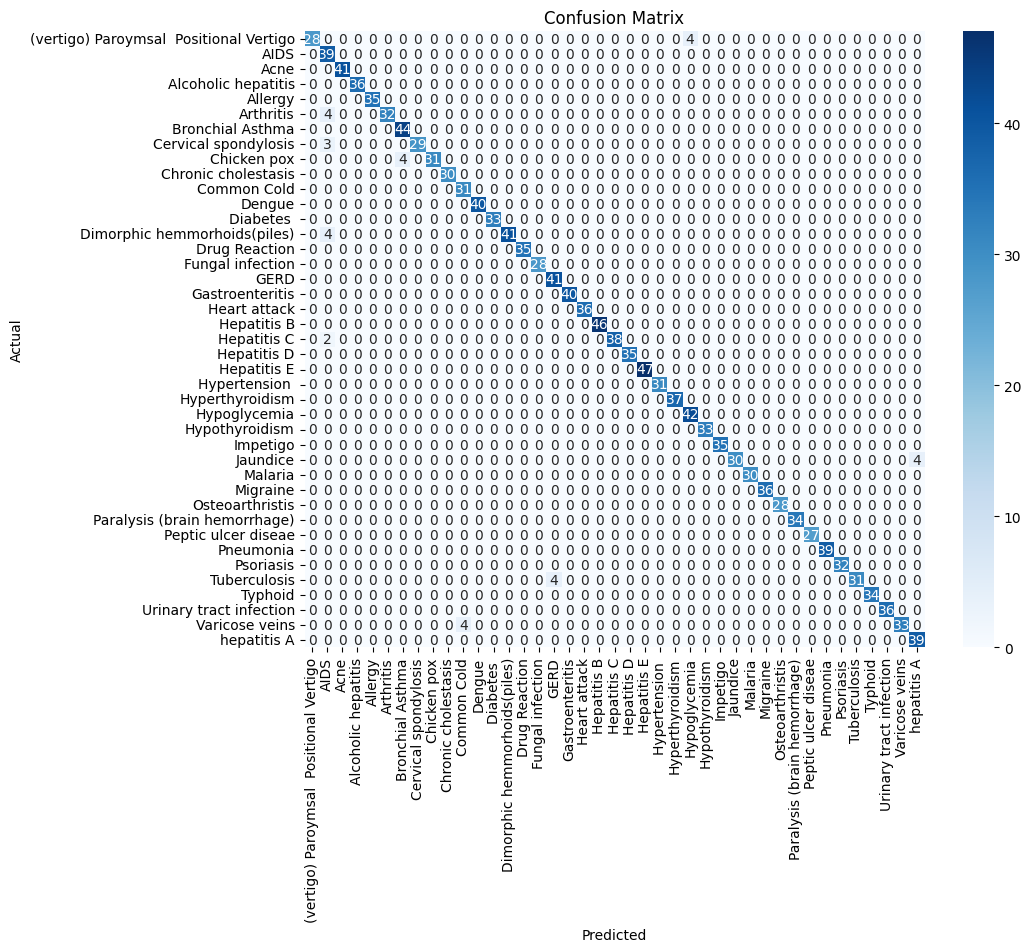

In [29]:
# --- NEW: Evaluation with Confusion Matrix and Classification Report ---
print("\n--- Model Evaluation ---")

# 1. Print Accuracy Score
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.2f}")

# 2. Print Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# 3. Print Confusion Matrix
print("\nConfusion Matrix:")
labels = sorted(np.unique(y_test))
cm = confusion_matrix(y_test, predictions, labels=labels)
print(cm)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Try to predict something else
What must the data be?
Need to have the same shape of binary data than X used for training
If I want to check a few symptoms I need to assign it to the correct index in the `all_symptoms` list

In [19]:
# Try to predict something else
# Some symptoms: 'itching', 'skin_rash', 'nodal_skin_eruptions', 'dischromic _patches'
def convert_symptoms_to_vector(symptoms, all_symptoms):
    ''' 
    Converts a list of symptoms into a binary vector based on the all_symptoms list.
    So the model can predict it.
    '''
    vector = np.zeros((1, len(all_symptoms)), dtype=int)
    for symptom in symptoms:
        if symptom in all_symptoms:
            vector[0, all_symptoms.index(symptom)] = 1
    return vector

new_symptoms1 = ['skin_rash', 'nodal_skin_eruptions', 'dischromic_patches']
new_symptoms2 = ['ulcers_on_tongue', 'cough', 'chest_pain']
# Combine the new symptoms into a frame with a row for each set of symptoms
new_symptoms = [new_symptoms1, new_symptoms2]
new_data = np.vstack([convert_symptoms_to_vector(symptoms, all_symptoms) for symptoms in new_symptoms])
print("New data symptoms vector: ", new_data)
new_prediction = model.predict(new_data)
print("Predicted disease for new symptoms: ", new_prediction)

New data symptoms vector:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
Predicted disease for new symptoms:  ['Psoriasis' 'Heart attack']


# Make a prediction with Input

In [23]:
# Input symptoms as a comma-separated string
input_symptoms = input("Enter symptoms separated by commas: ")

# Convert input string to a list of cleaned symptom names
user_symptoms = [s.strip() for s in input_symptoms.split(",") if s.strip()]

# Convert to binary vector
user_vector = convert_symptoms_to_vector(user_symptoms, all_symptoms)

# Predict disease
user_prediction = model.predict(user_vector)
print("Predicted disease for entered symptoms:", user_prediction[0])

Predicted disease for entered symptoms: AIDS
